In [1]:
import tensorflow as tf
import polars as pl
import numpy as np
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from window_generator import WindowGenerator

2023-03-30 10:24:14.888184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 10:24:14.932882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-30 10:24:14.935269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 10:24:15.935775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pl.read_csv("../data/prices/F_prices.csv")

# clean data
df.drop_in_place('Date')

# split data
train_df, val_df, test_df = utils.split_train_val_test(df, .7, .2)

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = train_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

val_df = val_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

test_df = test_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])


[Text(0, 0, 'Price'), Text(1, 0, 'Volume')]

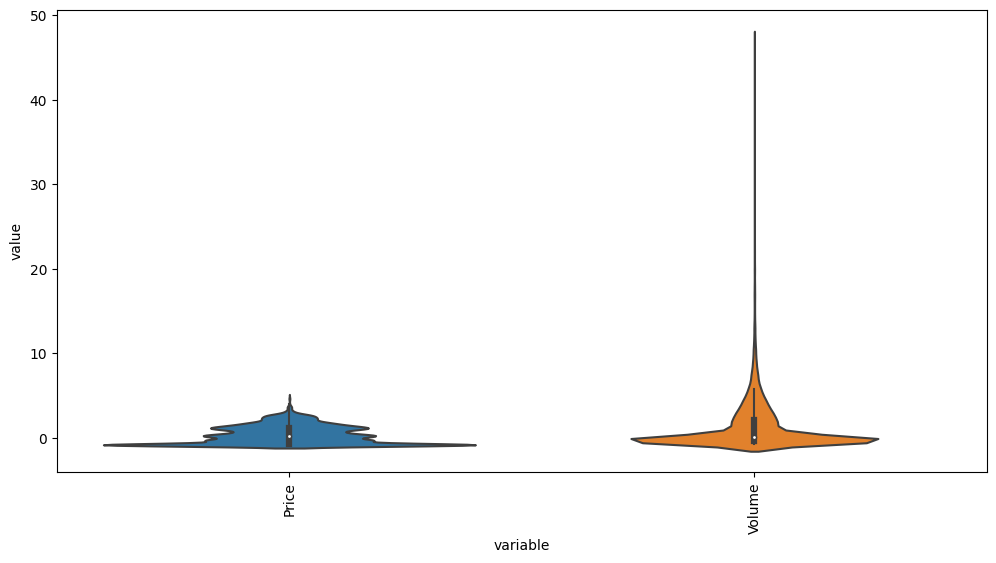

In [3]:
df_std = df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])
df_std = df_std.melt(value_vars=df_std.columns)
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='variable', y='value', data=df_std.to_pandas())
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

In [4]:
window = WindowGenerator(input_width=10, label_width=10, shift=1, label_columns=['Price'], train_df=train_df, val_df=val_df, test_df=test_df)

window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['Price']

In [5]:
example_window = tf.stack([train_df[:window.total_window_size].to_numpy(),
                           train_df[100:100+window.total_window_size].to_numpy(),
                           train_df[200:200+window.total_window_size].to_numpy()])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 11, 2)
Inputs shape: (3, 10, 2)
Labels shape: (3, 10, 1)


2023-03-30 10:24:18.075536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-30 10:24:18.075579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gone
2023-03-30 10:24:18.075587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gone
2023-03-30 10:24:18.075720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 515.86.1
2023-03-30 10:24:18.075745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 515.86.1
2023-03-30 10:24:18.075750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 515.86.1


In [6]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [7]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)


2023-03-30 10:24:18.324391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [8962]
	 [[{{node Placeholder/_8}}]]
2023-03-30 10:24:18.324816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


Input shape: (32, 10, 2)
Output shape: (32, 10, 1)


2023-03-30 10:24:18.581950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 10:24:18.585610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 10:24:18.587266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

history = lstm_model.fit(window.train, epochs=20,
                         validation_data=window.val,
                         callbacks=[])

Epoch 1/20


2023-03-30 10:24:18.958182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8972,2]
	 [[{{node Placeholder/_0}}]]
2023-03-30 10:24:18.958551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-03-30 10:24:19.172266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

278/281 [============================>.] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.2425

2023-03-30 10:24:23.181814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-03-30 10:24:23.182562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2554]
	 [[{{node Placeholder/_8}}]]
2023-03-30 10:24:23.459463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


281/281 [==============================] - 5s 9ms/step - loss: 0.1772 - mean_absolute_error: 0.2417 - val_loss: 0.1133 - val_mean_absolute_error: 0.2177
Epoch 2/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0301 - mean_absolute_error: 0.0830 - val_loss: 0.0551 - val_mean_absolute_error: 0.1389
Epoch 3/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0461 - val_loss: 0.0330 - val_mean_absolute_error: 0.1096
Epoch 4/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0273 - val_loss: 0.0235 - val_mean_absolute_error: 0.0943
Epoch 5/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0227 - val_loss: 0.0188 - val_mean_absolute_error: 0.0876
Epoch 6/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0206 - val_loss: 0.0146 - val_mean_absolute_error: 0.0752
Epoch 7/20
281/281 [=======

In [10]:
IPython.display.clear_output()
val_performance_lstm = lstm_model.evaluate(window.val)
performance_lstm = lstm_model.evaluate(window.test, verbose=0)

80/80 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_absolute_error: 0.0446


2023-03-30 10:24:59.430508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-03-30 10:24:59.430872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2564,2]
	 [[{{node Placeholder/_0}}]]
2023-03-30 10:24:59.662038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]

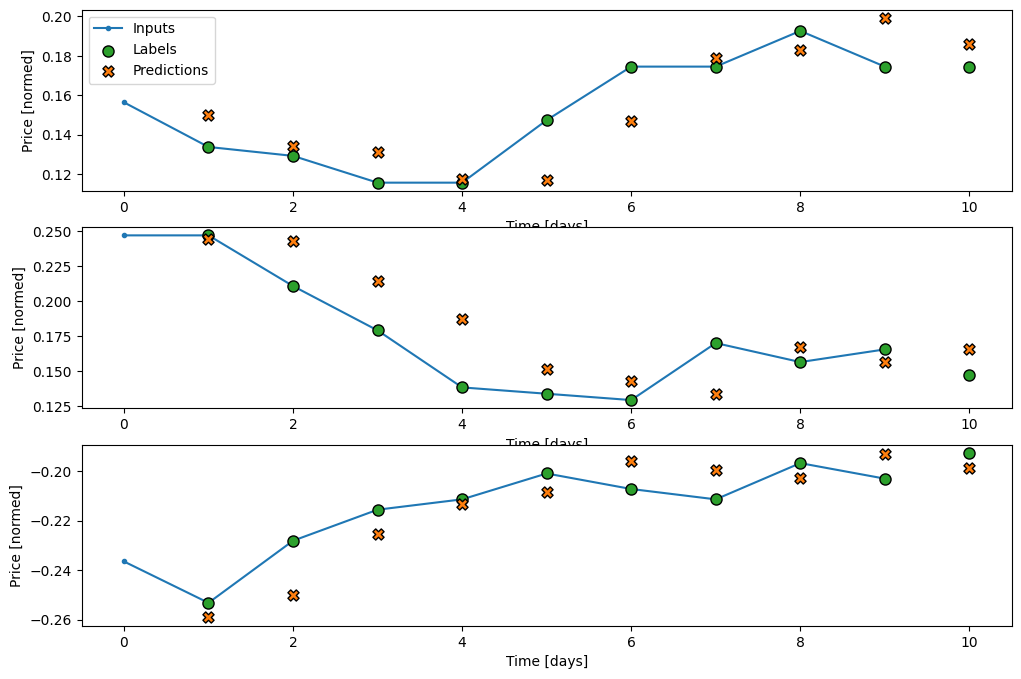

In [11]:
window.plot(lstm_model)